This notebook was developed in research described in paper:

Zelenkov Y. (2019) The Topics Dynamics in Knowledge Management Research. In: Uden L., Ting IH., Corchado J. (eds) Knowledge Management in Organizations. KMO 2019. Communications in Computer and Information Science, vol 1027. Springer, Cham, p. 324-335. DOI: 10.1007/978-3-030-21451-7_28

If you have any questions, please contact me mailto://yuri.zelenkov@gmail.com.

In [1]:
# Loading all necessary libraries
import numpy as np
import pandas as pd
import spacy
from time import time
from pprint import pprint

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

# NLTK Stop words
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer

# Gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

pd.set_option('precision',3)
np.set_printoptions(precision = 4)

In [2]:
df = pd.read_csv('pubs_KM.csv')
df.shape

(2058, 9)

In [3]:
df.head()

,Authors,Title,Year,Source,Volume,Issue,Abstract,Keywords,Cited
0,"Deshpande A., Gupta R.",Antecedents of new recruit's adjustment: An em...,2018,International Journal of Knowledge Management,14.0,4,The transition of newly hired employees from e...,Feedback seeking behavior; New recruit's adjus...,0.0
1,"Srivastava A.P., Joshi Y.",Examining the role of technology leadership on...,2018,International Journal of Knowledge Management,14.0,4,The purpose of this article is to examine the ...,Hotels; Information technology; Internet self-...,0.0
2,"Shaheen M., Krishnankutty R.",The mediation of psychological capital in the ...,2018,International Journal of Knowledge Management,14.0,4,Organizations become vulnerable to the loss of...,Extra-role performance; Flexible knowledge wor...,0.0
3,"Alqirem R.M., Alnaimi H.M., Shuhaiber A.",A best-practice model of university-students r...,2018,International Journal of Knowledge Management,14.0,4,A university-student relationship has been vie...,Relational bonds; Relationship strength; Stude...,0.0
4,"Lokshina I., Durkin B., Lanting C.",The IoT-and big data-driven data analysis serv...,2018,International Journal of Knowledge Management,14.0,4,"Ubiquitous sensing devices, enabled by wireles...",Big data; Business models; Business opportunit...,0.0


In [4]:
data = df.Abstract.tolist()

In [5]:
# Tokenization
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  
        # deacc=True removes punctuations
t0 = time()
data_words = list(sent_to_words(data))
print('Done in %.2f s' %(time() - t0))

Done in 3.88 s


In [6]:
# Remove stop words
def remove_stopwords(texts, stop_words):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

stop_words = stopwords.words('english')
stop_words.extend(['research','study','findings','implication','paper','article','author','model','framework',
                   'result','approach','methodology','purpose','use','publish','journal','novelty','book','science',
                   'whiley', 'john', 'son','knowledge','igi','review','theory','work'])

t0 = time()
data_words_nostops = remove_stopwords(data_words, stop_words)
print('Done in %.2f s' %(time() - t0))

Done in 3.70 s


In [7]:
# Make bigrams
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
t0 = time()
data_words_bigrams = make_bigrams(data_words_nostops)
print('Done in %.2f s' %(time() - t0))

Done in 1.89 s


In [8]:
# Lemmatization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' 
                                   for token in doc if token.pos_ in allowed_postags]))
    return texts_out

nlp = spacy.load('en', disable=['parser', 'ner'])
t0 = time()
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print('Done in %.2f s' %(time() - t0))

Done in 37.74 s


In [9]:
# Create Document-Word Matrix

vectorizer = CountVectorizer(analyzer='word',       
                             min_df = 10,                      # minimum reqd occurences of a word in corpus
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=300,             # max number of uniq words
                            )
t0 = time()
data_vectorized = vectorizer.fit_transform(data_lemmatized)
#data_vectorized = vectorizer.fit_transform(data_stemmed)
print('Done in %.2f s' %(time() - t0))

Done in 0.81 s


In [10]:
# Compute Sparsicity = Percentage of Non-Zero cells
data_dense = data_vectorized.todense()
print("Sparsicity: %.2f" %(((data_dense > 0).sum()/data_dense.size)*100), "%")

Sparsicity: 14.25 %


In [11]:
# Build LDA model and find best number of topics

n_topics = []
log_like = []
perpl = []


for n in range(3,15):
    lda_model = LatentDirichletAllocation(n_components=n,           # Number of topics
                                          learning_method='online',   
                                          random_state=100,          
                                          n_jobs = -1,               
                                          doc_topic_prior = 0.1,
                                          topic_word_prior = 0.5,
                                          learning_decay = 0.9)
    t0 = time()
    lda_output = lda_model.fit(data_vectorized) 
    l  = lda_model.score(data_vectorized)     # Log Likelyhood: Higher the better
    p = lda_model.perplexity(data_vectorized) # Perplexity: Lower the better. 

    print('n_topics = %2d : log_likelihood = %.0f perplexity = %.0f (%.2f s)' %(n, l, p, time()-t0))

    n_topics.append(n)
    log_like.append(l)
    perpl.append(p)

n_topics =  3 : log_likelihood = -744310 perplexity = 222 (54.47 s)
n_topics =  4 : log_likelihood = -743384 perplexity = 220 (54.62 s)
n_topics =  5 : log_likelihood = -743324 perplexity = 220 (50.77 s)
n_topics =  6 : log_likelihood = -742079 perplexity = 218 (53.19 s)
n_topics =  7 : log_likelihood = -742115 perplexity = 218 (54.57 s)
n_topics =  8 : log_likelihood = -741048 perplexity = 217 (48.06 s)
n_topics =  9 : log_likelihood = -741518 perplexity = 217 (43.50 s)
n_topics = 10 : log_likelihood = -741575 perplexity = 217 (31.31 s)
n_topics = 11 : log_likelihood = -741662 perplexity = 218 (31.50 s)
n_topics = 12 : log_likelihood = -741570 perplexity = 217 (31.44 s)
n_topics = 13 : log_likelihood = -741755 perplexity = 218 (30.72 s)
n_topics = 14 : log_likelihood = -742927 perplexity = 220 (30.18 s)


Text(0, 0.5, 'Log likelihood')

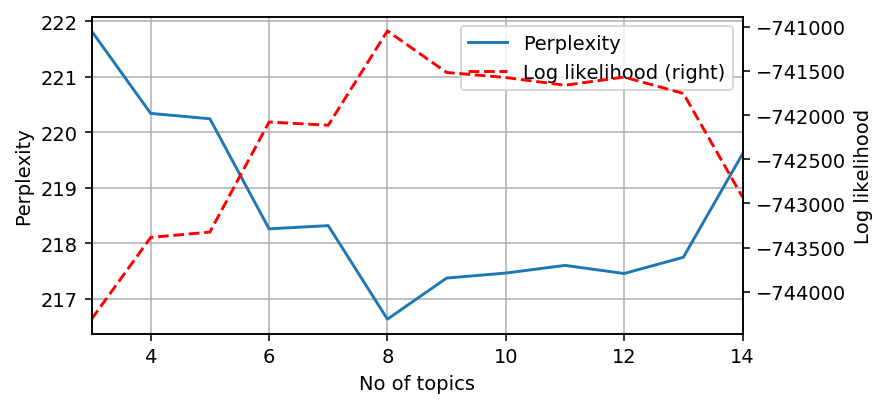

In [12]:
fig = plt.figure(dpi=140)
results = pd.DataFrame({'No of topics' : n_topics, 'Log likelihood' : log_like, 'Perplexity' : perpl})
results.set_index('No of topics', inplace = True)
results['Perplexity'].plot(figsize = (6,3), legend = True, ax = plt.gca())
plt.ylabel('Perplexity')
results['Log likelihood'].plot(secondary_y = True, style = 'r--', grid = True, legend = True, ax = plt.gca())
plt.ylabel('Log likelihood')

In [13]:
n_tops = 8  # Setting optimal number of topics

lda_model = LatentDirichletAllocation(n_components = n_tops,     
                                      # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters
                                      n_jobs = -1,               # Use all available CPUs
                                      doc_topic_prior = 0.1,
                                      topic_word_prior = 0.5,
                                      learning_decay = 0.9
                                     )
t0 = time()
lda_output = lda_model.fit(data_vectorized)
print('Done in %.2f s' %(time() - t0))
print("Log Likelihood: %.2f" %lda_model.score(data_vectorized))
print("Perplexity: %.2f" %lda_model.perplexity(data_vectorized))

Done in 29.37 s
Log Likelihood: -741041.15
Perplexity: 216.62


In [14]:
# Interactive tool for topics visuaization and analysis
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=             x        y  topics  cluster    Freq
topic                                           
4       41.401 -117.716       1        1  18.200
6      -87.108    7.684       2        1  16.261
2      -35.128   92.697       3        1  12.852
7       63.745  105.067       4        1  12.449
3       27.148   -3.775       5        1  11.257
5      135.059   35.474       6        1  10.938
0      -53.047  -85.958       7        1   9.361
1      125.117  -63.673       8        1   8.681, topic_info=    Category      Freq            Term     Total  loglift  logprob
197  Default  1781.000  organizational  1781.000   30.000   30.000
34   Default  1391.000         capital  1391.000   29.000   29.000
196  Default  1926.000    organization  1926.000   28.000   28.000
140  Default  1108.000      innovation  1108.000   27.000   27.000
202  Default  1438.000     performance  1438.000   26.000   26.000
250  Default  1045.000           share  1045.000   25.000   25.000
160  Default  1296.000           learn  1296.000   24.000   24.000
111  Default  1413.000            firm  1413.000   23.000   23.000
90   Default   695.000        employee   695.000   22.000   22.000
274  Default   520.000            team   520.000   21.000   21.000
146  Default   743.000    intellectual   743.000   20.000   20.000
251  Default   563.000         sharing   563.000   19.000   19.000
283  Default   786.000        transfer   786.000   18.000   18.000
288  Default   431.000      university   431.000   17.000   17.000
233  Default  1096.000    relationship  1096.000   16.000   16.000
218  Default   622.000         project   622.000   15.000   15.000
291  Default  2244.000           value  2244.000   14.000   14.000
84   Default   802.000          effect   802.000   13.000   13.000
161  Default   603.000        learning   603.000   12.000   12.000
43   Default  1123.000         company  1123.000   11.000   11.000
284  Default   327.000           trust   327.000   10.000   10.000
254  Default   266.000             sme   266.000    9.000    9.000
136  Default   585.000      individual   585.000    8.000    8.000
235  Default   478.000          report   478.000    7.000    7.000
65   Default   505.000         culture   505.000    6.000    6.000
215  Default  2039.000         process  2039.000    5.000    5.000
32   Default   428.000      capability   428.000    4.000    4.000
123  Default   462.000           human   462.000    3.000    3.000
255  Default   907.000          social   907.000    2.000    2.000
78   Default   292.000      disclosure   292.000    1.000    1.000
..       ...       ...             ...       ...      ...      ...
166   Topic8   248.336      literature  1021.136    1.030   -3.875
38    Topic8    55.530  characteristic   235.113    1.001   -5.372
47    Topic8    71.590      conceptual   308.603    0.983   -5.119
58    Topic8    47.976       corporate   206.879    0.983   -5.519
195   Topic8    89.558  organisational   402.700    0.941   -4.895
101   Topic8    68.245           exist   351.398    0.805   -5.166
116   Topic8    49.011             gap   263.693    0.761   -5.497
125   Topic8   155.910        identify   843.457    0.756   -4.340
16    Topic8    65.046         analyze   354.161    0.749   -5.214
203   Topic8    94.944     perspective   529.443    0.726   -4.836
61    Topic8   103.105        creation   578.560    0.719   -4.754
109   Topic8    56.735           field   325.199    0.698   -5.351
20    Topic8    42.690            area   248.719    0.682   -5.636
92    Topic8    51.278         enhance   308.569    0.649   -5.452
136   Topic8    96.741      individual   585.831    0.643   -4.817
144   Topic8    45.271       integrate   285.897    0.601   -5.577
81    Topic8    51.526         dynamic   325.681    0.600   -5.447
294   Topic8    53.666            view   341.824    0.593   -5.407
170   Topic8   332.652      management  2376.219    0.478   -3.582
164   Topic8   117.832      limitation   958.534  

In [15]:
lda_output = lda_model.transform(data_vectorized)

topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(data))]

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.shape

(2058, 9)

In [16]:
# Number of documents by dominant topic
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,4,470
1,6,373
2,2,271
3,3,230
4,7,214
5,5,213
6,0,161
7,1,126


In [17]:
# Building wordcloud for each topic
n_words = 10

keywords_frequency = []
words_weights_by_topic = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]
keywords = np.array(vectorizer.get_feature_names())

for topic in words_weights_by_topic:
    topic_words_frequency = {}
    for word, freq in zip(keywords, topic):
        topic_words_frequency.update({word : freq})
    keywords_frequency.append(topic_words_frequency)

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=n_words,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

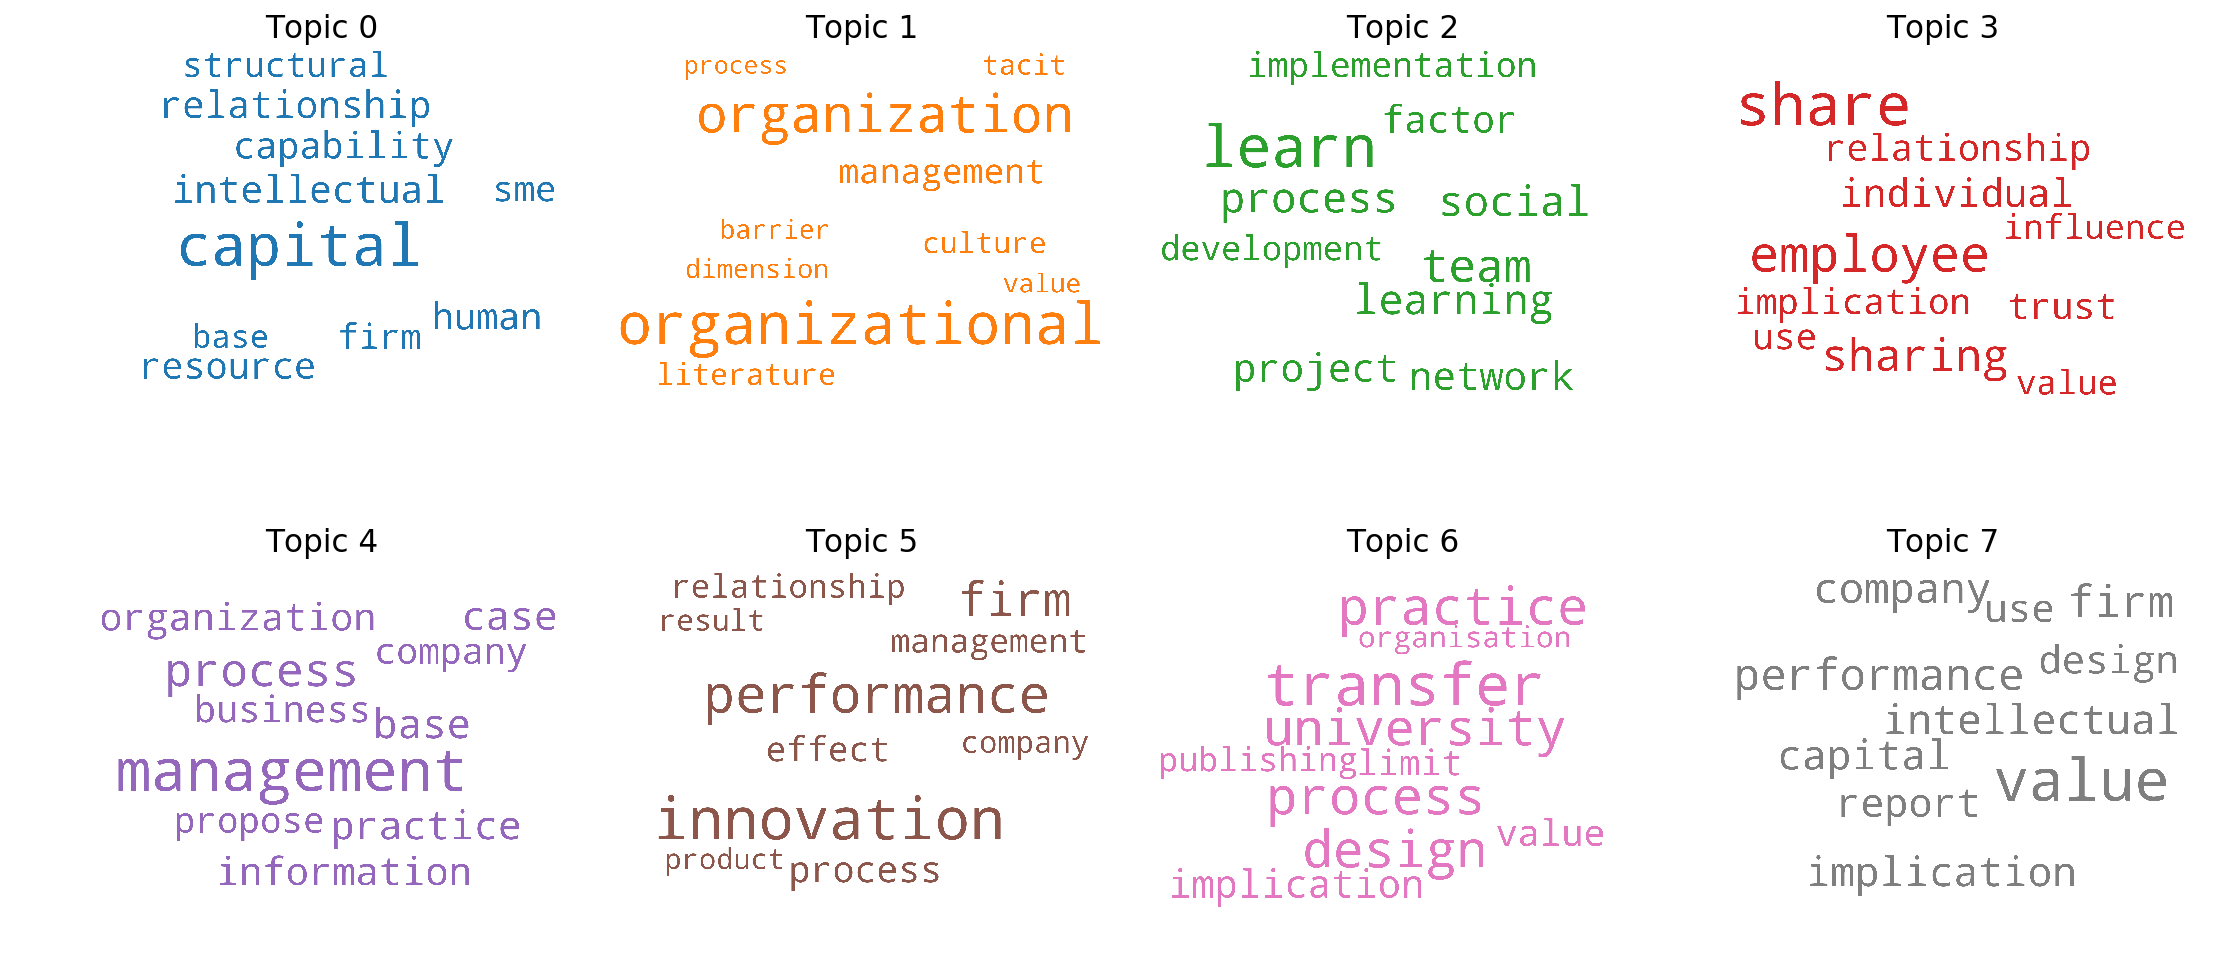

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(16,8), sharex=True, sharey=True, dpi = 140)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = keywords_frequency[i]
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [19]:
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,capital,intellectual,relationship,resource,human,capability,sme,firm,structural,base
Topic 1,organizational,organization,management,literature,culture,tacit,dimension,barrier,value,process
Topic 2,learn,team,social,process,learning,network,project,factor,implementation,development
Topic 3,share,employee,sharing,individual,relationship,trust,use,implication,value,influence
Topic 4,management,process,base,case,practice,information,organization,business,company,propose
Topic 5,innovation,performance,firm,process,effect,management,relationship,company,result,product
Topic 6,transfer,practice,process,design,university,implication,value,limit,publishing,organisation
Topic 7,value,firm,performance,company,intellectual,capital,implication,report,use,design


#### 2.Distribution of pubs

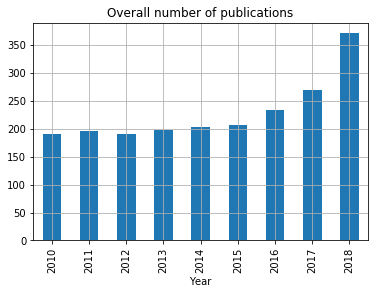

In [20]:
df = pd.concat([df, df_document_topic.reset_index(drop = True)], axis=1, join='inner')
df.loc[df['Source'] == 'Learning Organization', 'Source'] = 'The Learning Organization'

abbr = {'Journal of Knowledge Management'            : 'JKM',
        'Knowledge Management Research and Practice' : 'KRP',
        'Journal of Intellectual Capital'            : 'JIC',
        'The Learning Organization'                  : 'TLO',
        'Knowledge and Process Management'           : 'KPM',
        'International Journal of Knowledge Management' : 'IJK',
        'VINE Journal of Information and Knowledge Management Systems' : 'VIN'}

df['Abbr'] = [abbr[key] for key in df.Source]
df.groupby('Year').Title.count().plot.bar(grid = True, title = 'Overall number of publications')

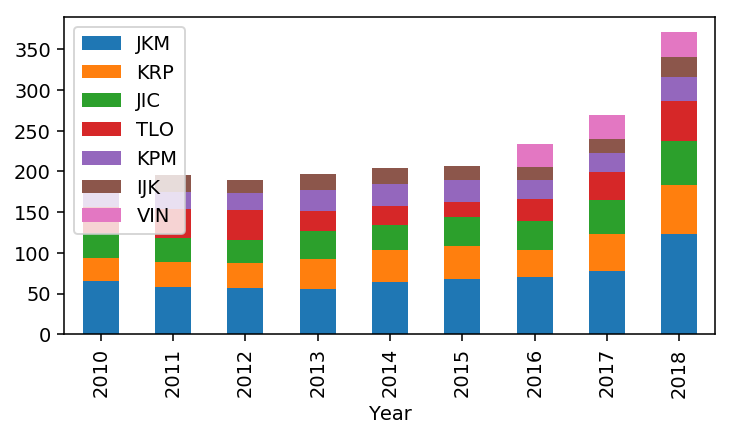

In [21]:
df2 = pd.DataFrame()
year = list(df.Year.value_counts().index)
source = list(df.Abbr.value_counts().index)

for s in source:
    df2[s] = df[df.Abbr == s].groupby('Year').Title.count()

fig = plt.figure(dpi=140)    
df2.plot.bar(stacked = True, figsize = (6,3), ax = plt.gca())

#### 3. Topic popularity

In [22]:
# Topic overall popularity

topics = ['Topic0', 'Topic1', 'Topic2', 'Topic3', 'Topic4','Topic5', 'Topic6', 'Topic7']
df[topics].sum() / df.shape[0]

Topic0    0.083
Topic1    0.085
Topic2    0.135
Topic3    0.109
Topic4    0.195
Topic5    0.109
Topic6    0.164
Topic7    0.111
dtype: float64

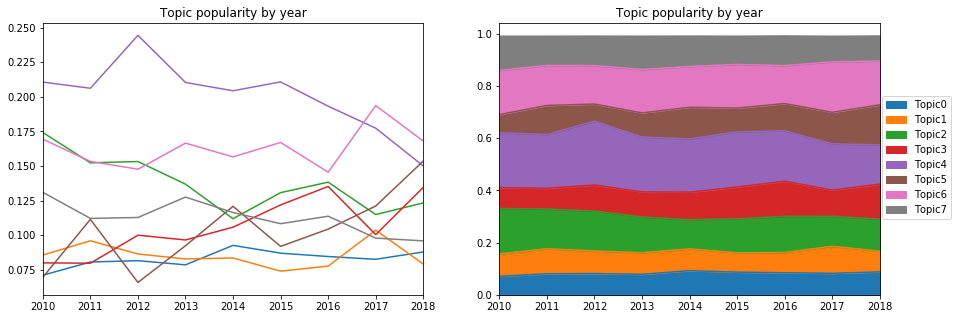

In [23]:
# Topic popularity by year
df3 = df.groupby('Year')[topics].sum().T / df.Year.value_counts()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
df3.T.plot(ax=axes[0], legend = False); axes[0].set_title('Topic popularity by year');
df3.T.plot.area(ax=axes[1]).legend(bbox_to_anchor=(1.2, 0.75)); axes[1].set_title('Topic popularity by year');

In [24]:
# Trend lines (beta coefficients) for topic popularity

from sklearn.linear_model import LinearRegression
lr = LinearRegression()

for t in topics:
    x = np.array(df3.loc[t].index).reshape(-1, 1)
    y = df3.loc[t].values
    lr.fit(x,y)
    print(t,':',lr.coef_)

Topic0 : [0.0015]
Topic1 : [-0.0005]
Topic2 : [-0.0059]
Topic3 : [0.0063]
Topic4 : [-0.0072]
Topic5 : [0.0074]
Topic6 : [0.0019]
Topic7 : [-0.0033]


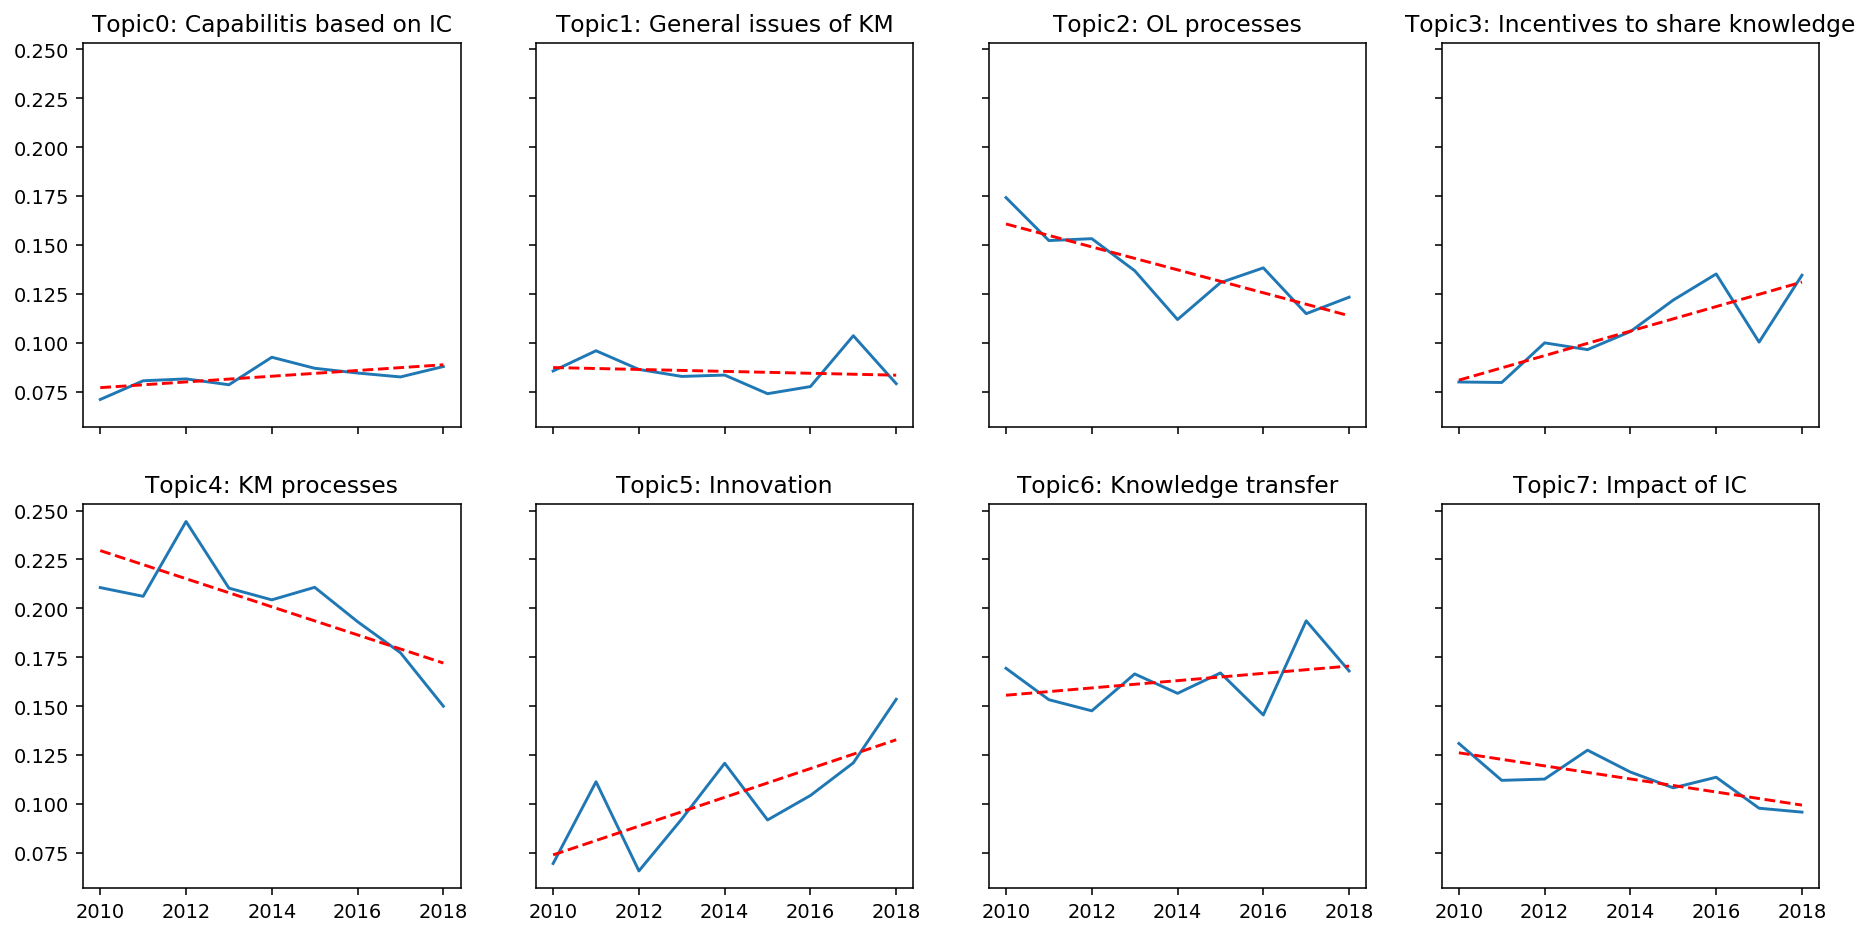

In [25]:
topic_descr = ['Capabilitis based on IC','General issues of KM','OL processes', 'Incentives to share knowledge',
               'KM processes','Innovation','Knowledge transfer', 'Impact of IC']


fig, axes = plt.subplots(2, 4, figsize=(16,8), sharex=True, sharey=True, dpi = 140)
i = 0
for t,ax in zip(topics,axes.flatten()):
    fig.add_subplot(ax)

    x = np.array(df3.loc[t].index).reshape(-1, 1)
    y = df3.loc[t].values
    lr.fit(x,y)
    plt.plot(x, y)
    plt.plot(x, lr.predict(x),'r--')
    plt.title(t+': '+topic_descr[i])
    i += 1

#### 4. Topic impact

In [26]:
# Overall topic impact

m = np.array(df[topics]) 
v = np.array(df.Cited)
df4 = pd.DataFrame(m * v[:, np.newaxis], columns = topics)
df4['Abbr'] = df.Abbr
df4['Year'] = df.Year
df4['Cited'] = df.Cited

df4[topics].sum() / df4.Cited.sum()

Topic0    0.101
Topic1    0.094
Topic2    0.101
Topic3    0.121
Topic4    0.163
Topic5    0.091
Topic6    0.167
Topic7    0.153
dtype: float64

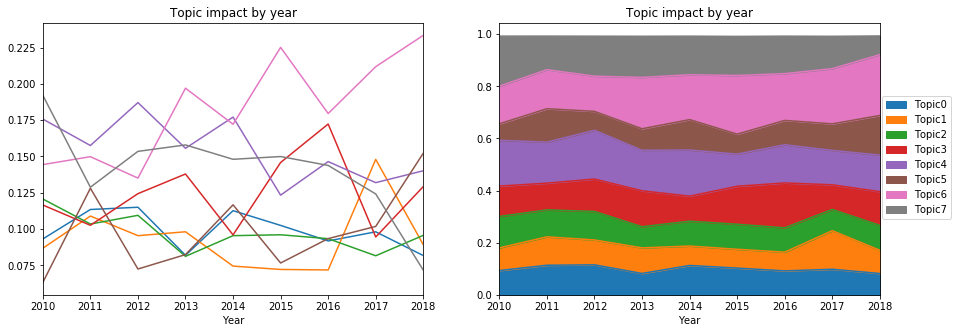

In [27]:
df5  = df4.groupby('Year')[topics].sum().T / df4.groupby('Year').Cited.sum()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
df5.T.plot(ax=axes[0], legend = False); axes[0].set_title('Topic impact by year');
df5.T.plot.area(ax=axes[1]).legend(bbox_to_anchor=(1.2, 0.75)); axes[1].set_title('Topic impact by year');

In [28]:
# Trend lines (beta coefficients) for topic impact
lr = LinearRegression()

for t in topics:
    x = np.array(df5.loc[t].index).reshape(-1, 1)
    y = df5.loc[t].values
    lr.fit(x,y)
    print(t,':',lr.coef_)

Topic0 : [-0.002]
Topic1 : [0.0009]
Topic2 : [-0.0031]
Topic3 : [0.0022]
Topic4 : [-0.0055]
Topic5 : [0.0052]
Topic6 : [0.011]
Topic7 : [-0.0087]


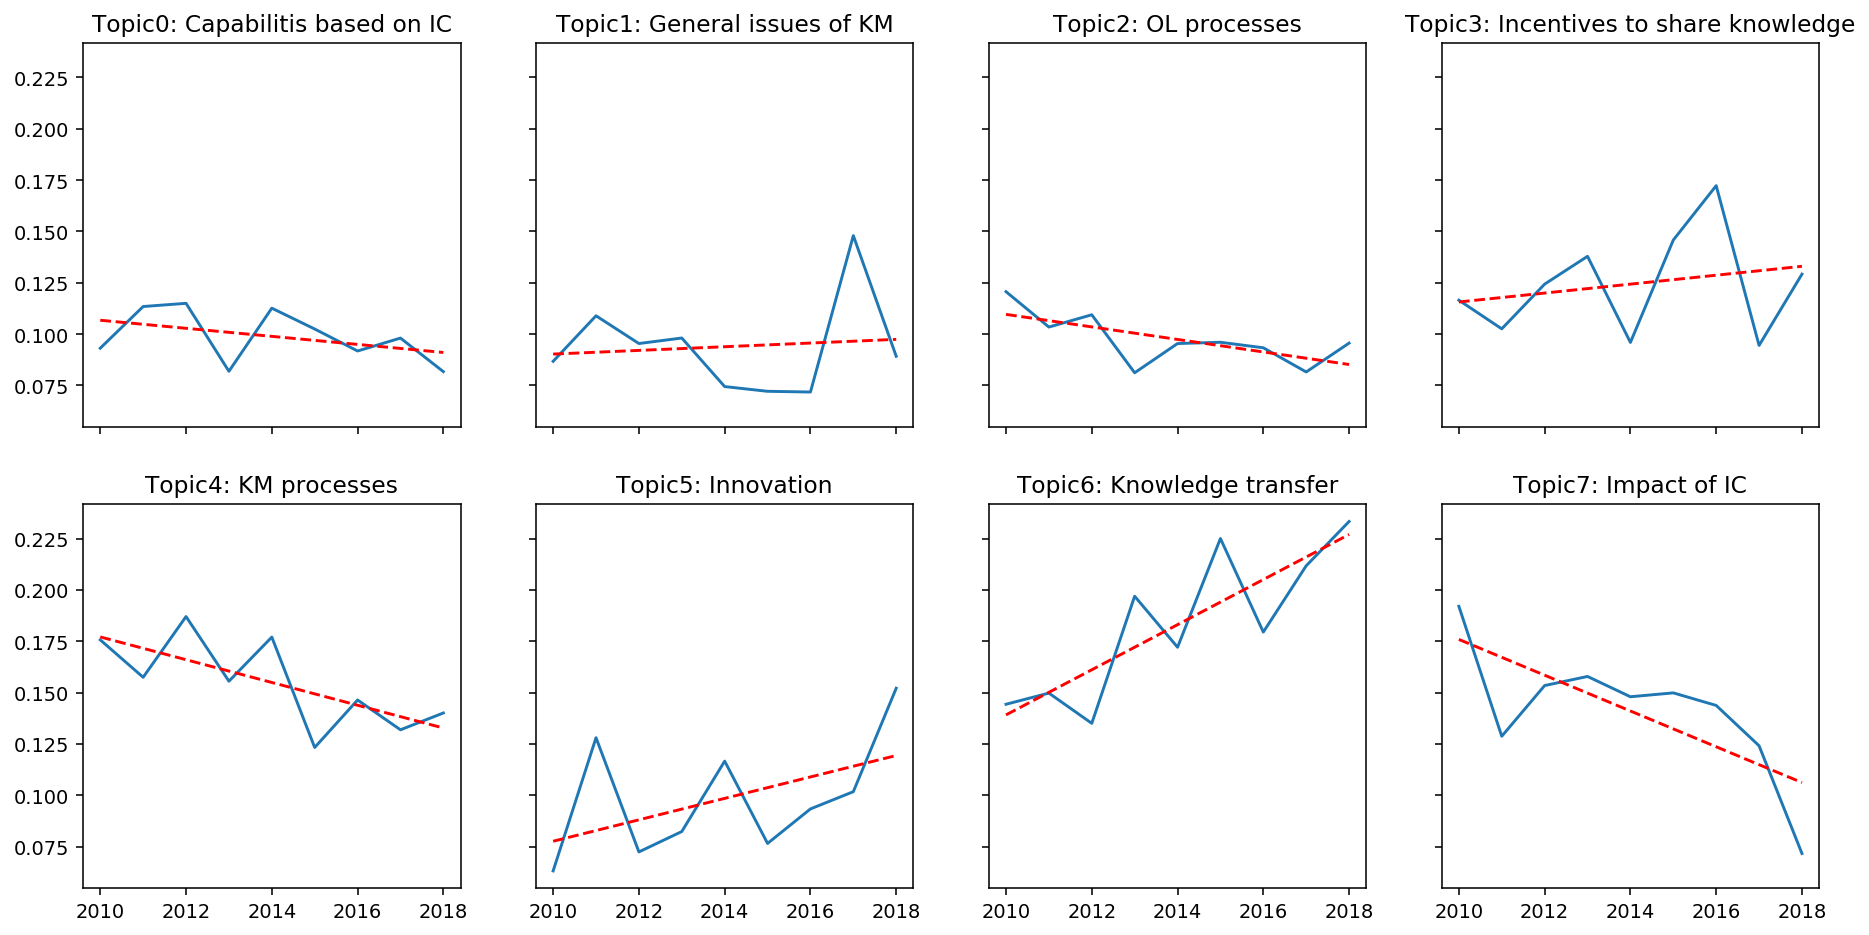

In [29]:
fig, axes = plt.subplots(2, 4, figsize=(16,8), sharex=True, sharey=True, dpi = 140)
i = 0
for t,ax in zip(topics,axes.flatten()):
    fig.add_subplot(ax)

    x = np.array(df5.loc[t].index).reshape(-1, 1)
    y = df5.loc[t].values
    lr.fit(x,y)
    plt.plot(x, y)
    plt.plot(x, lr.predict(x),'r--')
    plt.title(t+': '+topic_descr[i])
    i += 1

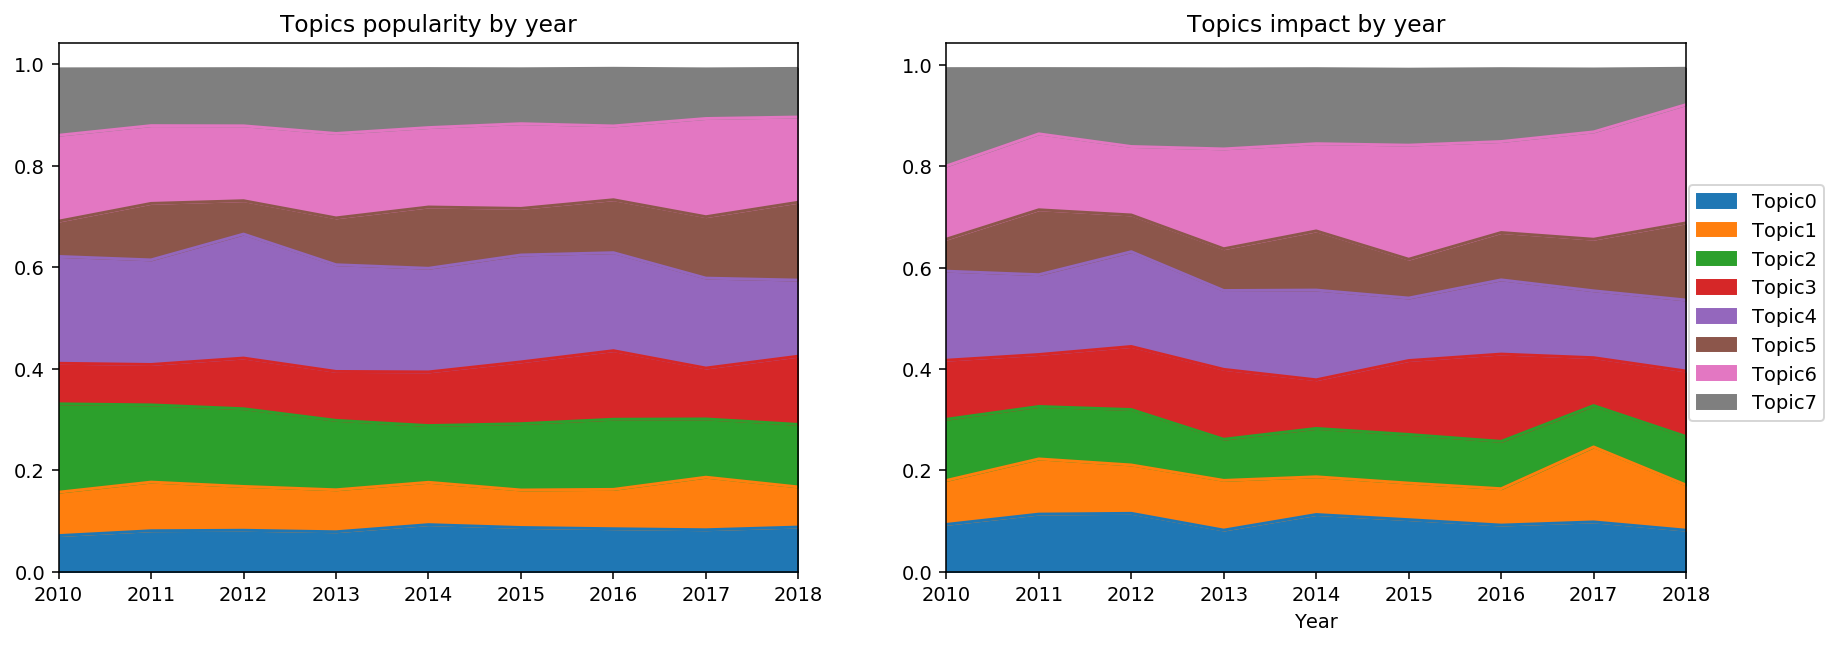

In [30]:
# Final picture

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,5), dpi = 140)
df3.T.plot.area(ax=axes[0], legend = False); axes[0].set_title('Topics popularity by year');
df5.T.plot.area(ax=axes[1]).legend(bbox_to_anchor=(1.2, 0.75)); axes[1].set_title('Topics impact by year');

#### 5. Journal uniqueness

In [31]:
# average number of citation by journal in 2017 

print(df[df.Year == 2017].groupby('Source').Cited.sum() / df[df.Year == 2017].groupby('Source').Cited.count())

Source
International Journal of Knowledge Management                   0.765
Journal of Intellectual Capital                                 5.810
Journal of Knowledge Management                                 5.949
Knowledge Management Research and Practice                      2.311
Knowledge and Process Management                                1.417
The Learning Organization                                       4.265
VINE Journal of Information and Knowledge Management Systems    1.828
Name: Cited, dtype: float64


In [32]:
# Distribuiton of topics other journals

import seaborn as sns
cm = sns.light_palette("blue", as_cmap=True)

df6 = df.groupby('Source')[topics].sum() / df[topics].sum()

new_topic_names = {}
for t, t_descr in zip(topics, topic_descr):
    new_topic_names[t] = t_descr


s = df6.style.background_gradient(cmap=cm)
s

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7
Source,,,,,,,,
International Journal of Knowledge Management,0.0315,0.0758,0.104,0.118,0.124,0.102,0.0452,0.0158
Journal of Intellectual Capital,0.385,0.0365,0.0288,0.0269,0.0747,0.0638,0.15,0.607
Journal of Knowledge Management,0.236,0.367,0.259,0.462,0.294,0.347,0.339,0.198
Knowledge Management Research and Practice,0.19,0.153,0.264,0.116,0.172,0.241,0.126,0.0603
Knowledge and Process Management,0.0782,0.0819,0.0792,0.0663,0.217,0.174,0.0437,0.0363
The Learning Organization,0.0425,0.259,0.223,0.134,0.0686,0.0456,0.249,0.0579
VINE Journal of Information and Knowledge Management Systems,0.0376,0.0274,0.0418,0.0767,0.0496,0.0253,0.048,0.0241


In [33]:
# Distribuiton of topics other journals in year = 2018

import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)

df6 = df[df.Year == 2018].groupby('Source')[topics].sum() / df[df.Year == 2018][topics].sum()
df6.rename(columns = new_topic_names, inplace = True)
s = df6.style.background_gradient(cmap=cm)
s

,Capabilitis based on IC,General issues of KM,OL processes,Incentives to share knowledge,KM processes,Innovation,Knowledge transfer,Impact of IC
Source,,,,,,,,
International Journal of Knowledge Management,0.0224,0.0644,0.0474,0.137,0.096,0.0715,0.0319,0.0191
Journal of Intellectual Capital,0.299,0.0341,0.019,0.0248,0.087,0.0376,0.188,0.621
Journal of Knowledge Management,0.376,0.327,0.239,0.432,0.298,0.457,0.273,0.235
Knowledge Management Research and Practice,0.148,0.0913,0.279,0.107,0.162,0.25,0.141,0.0478
Knowledge and Process Management,0.0604,0.0818,0.0614,0.0747,0.183,0.112,0.0306,0.00928
The Learning Organization,0.00736,0.341,0.288,0.092,0.035,0.0165,0.279,0.00787
VINE Journal of Information and Knowledge Management Systems,0.0871,0.06,0.0665,0.132,0.139,0.0557,0.0573,0.0596


#### 6. Alternative visualization

In [34]:
from sklearn.manifold import TSNE

In [35]:
tsne_model = TSNE(n_components = 2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(lda_output)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2058 samples in 0.004s...
[t-SNE] Computed neighbors for 2058 samples in 0.153s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2058
[t-SNE] Computed conditional probabilities for sample 2000 / 2058
[t-SNE] Computed conditional probabilities for sample 2058 / 2058
[t-SNE] Mean sigma: 0.120965
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.949799
[t-SNE] KL divergence after 1000 iterations: 0.952871


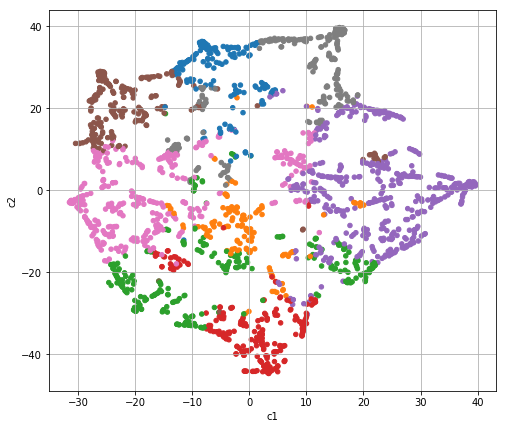

In [37]:
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
df_tsne = pd.DataFrame(tsne_lda, columns = ['c1','c2'])
df_tsne['topic'] = df_document_topic.dominant_topic.values
df_tsne.plot.scatter(x = 'c1', y = 'c2', c = mycolors[df_tsne.topic], figsize = (8,7), grid = True)

#### 7. Most representative paper for each topic

In [38]:
# Most representative paper for each topic
def best_paper(topic):
    paper = df.sort_values(by = ['Topic'+str(topic),'Cited'], ascending = False).head(1)
    print(paper.Authors.values[0] + ' (' + str(paper.Year.values[0]) +') ' + paper.Title.values[0] +'. ' + 
          paper.Source.values[0] + ', ' + str(pd.to_numeric(paper.Volume.values[0], downcast='integer'))  + ':' + 
          str(pd.to_numeric(paper.Issue.values[0], downcast='integer')))
    print('Topic' + str(topic)+' : ' + str(paper['Topic'+str(topic)].values[0]) + ' Cited :', paper.Cited.values[0])
    print()

In [39]:
for topic in range(0,n_tops):
    best_paper(topic)
    print('\n')

Kamukama N., Ahiauzu A., Ntayi J.M. (2011) Competitive advantage: Mediator of intellectual capital and performance. Journal of Intellectual Capital, 12.0:1
Topic0 : 0.99 Cited : 56.0



Nobre F.S., Walker D.S. (2011) A dynamic ability-based view of the organization. International Journal of Knowledge Management, 7.0:2
Topic1 : 0.99 Cited : 9.0



Cauwelier P., Ribière V.M., Bennet A. (2016) Team psychological safety and team learning: a cultural perspective. The Learning Organization, 23.0:6
Topic2 : 0.99 Cited : 1.0



Rutten W., Blaas - Franken J., Martin H. (2016) The impact of (low) trust on knowledge sharing. Journal of Knowledge Management, 20.0:2
Topic3 : 0.99 Cited : 26.0



Minonne C., Turner G. (2012) Business Process Management-Are You Ready for the Future?. Knowledge and Process Management, 19.0:3
Topic4 : 0.99 Cited : 22.0



Wang C., Han Y. (2011) Linking properties of knowledge with innovation performance: The moderate role of absorptive capacity. Journal of Knowledge Ma